# FLUX.1

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/flux.ipynb)

See [announcing Black Forest Labs](https://blackforestlabs.ai/announcing-black-forest-labs/).

On Colab, currently only A100 can run the original bf16 checkpoints. Even with model CPU offloading, the Transformer won't fit on L4. Sequential CPU offloading works but is too slow. I'm waiting for better quantization and single file support in Diffusers; flux-jupyter uses the Comfy model management code. Stay tuned...

In [1]:
# @title Install
import os
import sys
import subprocess
from importlib.util import find_spec

modules = ["accelerate", "diffusers", "hf_transfer", "sentencepiece", "transformers"]
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "protobuf", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# @title Imports
import gc
import os
from datetime import datetime
from hashlib import md5
from io import BytesIO
from warnings import filterwarnings

import torch
from PIL import Image
from diffusers import FlowMatchEulerDiscreteScheduler, FlowMatchHeunDiscreteScheduler, FluxPipeline
from transformers import logging

In [3]:
# @title Environment
try:
    from google.colab import userdata

    HF_TOKEN = userdata.get("HF_TOKEN")
except ImportError:
    HF_TOKEN = os.environ.get("_HF_TOKEN", None) or os.environ.get("HF_TOKEN", "")
finally:
    os.environ["HF_TOKEN"] = HF_TOKEN
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

filterwarnings("ignore", category=FutureWarning, module="diffusers")
filterwarnings("ignore", category=FutureWarning, module="transformers")
logging.set_verbosity_error()

In [4]:
# @title Pipeline
class Loader:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.pipe = None
            cls._instance.model = None
        return cls._instance

    def _flush(self):
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    def _load_pipeline(self, model, cpu_offload, tqdm, **kwargs):
        if self.pipe is None:
            try:
                print(f"Loading {model}...")
                self.model = model
                self.pipe = FluxPipeline.from_pretrained(model, **kwargs)
                if cpu_offload:
                    self.pipe.enable_model_cpu_offload()
                else:
                    self.pipe.to("cuda")
            except Exception as e:
                print(e)
                self.pipe = None
                self.model = None
        if self.pipe is not None:
            self.pipe.set_progress_bar_config(disable=not tqdm)

    def _should_unload_pipeline(self, model):
        if self.pipe is None:
            return False
        if self.model.lower() != model.lower():
            return True
        return False

    def _unload(self, model):
        items = []
        if self._should_unload_pipeline(model):
            items.append("pipe")
            items.append("model")
        for item in items:
            delattr(self, items)
        self._flush()
        for item in items:
            setattr(self, item, None)

    def load(self, model, scheduler, cpu_offload, tqdm):
        schedulers = {
            "Euler": FlowMatchEulerDiscreteScheduler,
            "Heun": FlowMatchHeunDiscreteScheduler,
        }
        pipe_kwargs = {
            "torch_dtype": torch.bfloat16,
            "scheduler": schedulers[scheduler](),  # use defaults
        }
        self._unload(model)
        self._load_pipeline(model, cpu_offload, tqdm, **pipe_kwargs)

        # error
        if self.pipe is None:
            return

        same_scheduler = isinstance(self.pipe.scheduler, schedulers[scheduler])
        if not same_scheduler:
            print(f"Switching to {scheduler}...")
            self.pipe.scheduler = schedulers[scheduler]()

In [5]:
# @title Inference
def main():
    global \
        MODEL, \
        SCHEDULER, \
        PROMPT, \
        SEED, \
        OUT_DIR, \
        WIDTH, \
        HEIGHT, \
        GUIDANCE_SCALE, \
        INFERENCE_STEPS, \
        CPU_OFFLOAD, \
        PROGRESS

    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available")

    if torch.cuda.get_device_properties("cuda").major < 8:
        raise RuntimeError("bfloat16 requires compute capability 8.x")

    if SEED is None or SEED < 0:
        seed = int(datetime.now().timestamp() * 1e6) % 2**64
    else:
        seed = SEED

    loader = Loader()
    loader.load(MODEL, SCHEDULER, CPU_OFFLOAD, PROGRESS)

    if loader.pipe is None:
        return

    pipe = loader.pipe

    try:
        image = pipe(
            width=WIDTH,
            height=HEIGHT,
            prompt=PROMPT,
            num_inference_steps=INFERENCE_STEPS,
            generator=torch.Generator(device=pipe.device).manual_seed(seed),
            guidance_scale=GUIDANCE_SCALE if MODEL.lower() == "black-forest-labs/flux.1-dev" else 0.0,
        ).images[0]
    except Exception as e:
        print(e)
        return

    image_file = save_image(image, OUT_DIR)
    print(image_file)
    display(Image.open(image_file))


# save image using content-based hash
def save_image(image, out_dir="."):
    image_bytes = BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes.seek(0)
    image_hash = md5(image_bytes.read()).hexdigest()
    filename = f"{out_dir}/{image_hash}.png"
    image.save(filename)
    return filename

/workspace/885cf0ed3959e70dd0f5f00af488fe17.png


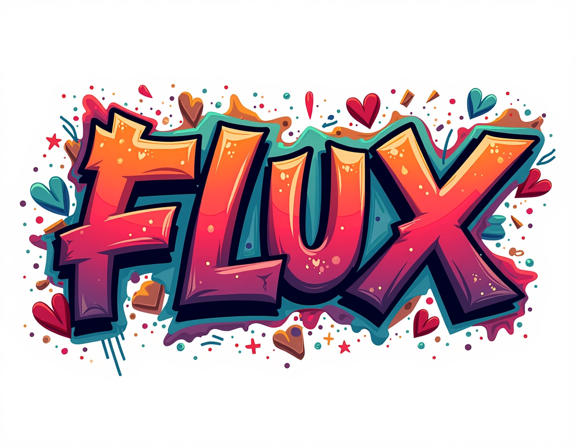

In [6]:
# fmt: off
MODEL = "black-forest-labs/FLUX.1-dev"  # @param {type:"string"} ["black-forest-labs/FLUX.1-dev", "black-forest-labs/FLUX.1-schnell"]
SCHEDULER = "Euler"  # @param {type:"string"} ["Euler", "Heun"]
PROMPT = "The word \"FLUX\" written in a bold and vibrant graffiti style."  # @param {type:"string"}
OUT_DIR = "/workspace"  # @param {type:"string"}
SEED = 1725733909744807  # @param {type:"integer", min: -1, max: 18446744073709551615}
WIDTH = 1152  # @param {type:"slider", min: 768, max: 1536, step: 64}
HEIGHT = 896  # @param {type:"slider", min: 768, max: 1536, step: 64}
GUIDANCE_SCALE = 4.0  # @param {type:"slider", min: 0, max: 10, step: 0.1}
INFERENCE_STEPS = 30  # @param {type:"slider", min: 1, max: 50, step: 1}
CPU_OFFLOAD = False  # @param {type:"boolean"}
PROGRESS = False  # @param {type:"boolean"}
main()